In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import mysql.connector

db=mysql.connector.connect(
    host='localhost',
    username='root',
    password='Shubhi@22',
    database='ecommerce'
)
cur=db.cursor()


## List all unique cities where customers are located.

In [3]:
query= """ SELECT DISTINCT(customer_city) FROM customers"""
cur.execute(query)
data=cur.fetchall()
dF=pd.DataFrame(data)
dF.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


## Count the number of orders placed in 2017.

In [4]:
query= """ SELECT COUNT(*) FROM orders WHERE YEAR(order_purchase_timestamp)=2017"""
cur.execute(query)
data=cur.fetchall()
"Total orders placed in 2017 are:", data[0][0]

('Total orders placed in 2017 are:', 45101)

## Find the total sales per category.

In [5]:
query = """ select UPPER(products.product_category) category, ROUND(sum(payments.payment_value),2) sales
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category
"""
cur.execute(query)
data=cur.fetchall()
dF=pd.DataFrame(data,columns=["Category","Sales"])
dF


,Category,Sales
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,BED TABLE BATH,1712553.67
4,AUTOMOTIVE,852294.33
...,...,...
69,CDS MUSIC DVDS,1199.43
70,LA CUISINE,2913.53
71,FASHION CHILDREN'S CLOTHING,785.67
72,PC GAMER,2174.43


## Calculate the percentage of orders that were paid in installments

In [6]:
query = """ SELECT (SUM(
                        CASE 
                        WHEN payment_installments>=1 THEN 1
                        ELSE 0
                        END
                        ))/COUNT(*)*100
                    FROM payments
"""
cur.execute(query)
data=cur.fetchall()
"the percentage of orders that were paid in installments is", data[0][0]

('the percentage of orders that were paid in installments is',
 Decimal('99.9981'))

## Count the number of customers from each state

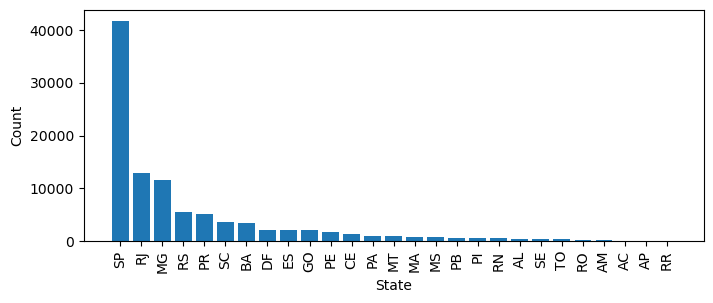

In [7]:
query = """ SELECT customer_state,COUNT(customer_id) FROM customers
GROUP BY customer_state
"""
cur.execute(query)
data=cur.fetchall()
dF=pd.DataFrame(data,columns=["State","Count"])
dF=dF.sort_values(by="Count",ascending=False)

plt.figure(figsize=(8,3))
plt.bar(dF["State"],dF["Count"])
plt.xlabel("State")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()

## Calculate the number of orders per month in 2018

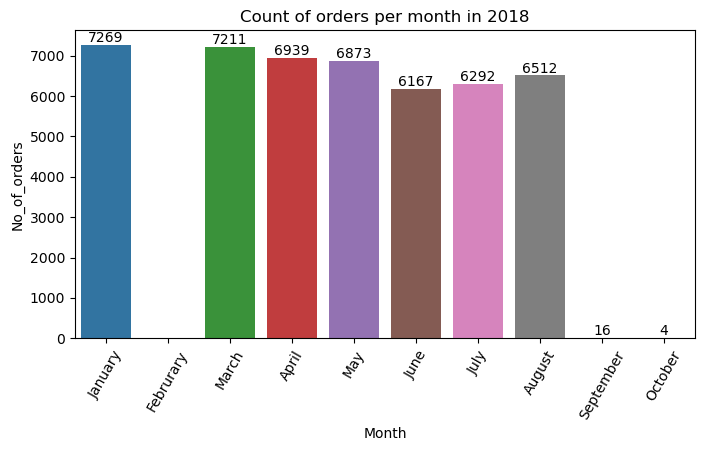

In [8]:
query= """ SELECT MONTHNAME(order_purchase_timestamp),COUNT(order_id) FROM orders WHERE YEAR(order_purchase_timestamp)=2018
GROUP BY MONTHNAME(order_purchase_timestamp)"""
cur.execute(query)
data=cur.fetchall()
dF=pd.DataFrame(data,columns=["Month","No_of_orders"])
o=["January","Februrary","March","April","May","June","July","August","September","October"]

plt.figure(figsize=(8,4))
ax=sns.barplot(x=dF["Month"],y=dF["No_of_orders"],data=dF,order=o)
plt.xticks(rotation=60)
ax.bar_label(ax.containers[0])
plt.title("Count of orders per month in 2018")
plt.show()

## Find the average number of products per order, grouped by customer city

In [9]:
query = """ 
    with count_per_order as(
        SELECT orders.order_id,orders.customer_id,COUNT(order_items.order_id) as oc
        FROM orders JOIN order_items 
        ON orders.order_id=order_items.order_id
        GROUP BY orders.order_id,orders.customer_id
        )
    SELECT customers.customer_city,ROUND(AVG(count_per_order.oc),2)
    FROM customers JOIN count_per_order
    ON customers.customer_id=count_per_order.customer_id
    GROUP BY customers.customer_city
"""
cur.execute(query)
data=cur.fetchall()
dF=pd.DataFrame(data,columns=["Customer_city","Average_orders"])
dF.head(10)

,Customer_city,Average_orders
0,sao paulo,1.16
1,sao jose dos campos,1.14
2,porto alegre,1.17
3,indaial,1.12
4,treze tilias,1.27
5,rio de janeiro,1.15
6,mario campos,1.33
7,guariba,1.00
8,cuiaba,1.20
9,franca,1.25


## Calculate the percentage of total revenue contributed by each product category

In [10]:
query = """
    SELECT UPPER(products.product_category) category, ROUND((SUM(payments.payment_value)/(SELECT SUM(payment_value) FROM payments))*100,2)  AS Sales_percentage
    FROM products JOIN order_items
    ON products.product_id=order_items.product_id
    JOIN payments
    ON order_items.order_id=payments.order_id
    GROUP BY category
    
    
"""
cur.execute(query)
data=cur.fetchall()
dF=pd.DataFrame(data,columns=["Product_Category","Revenue_percentage"])
dF.head(10)

,Product_Category,Revenue_percentage
0,PERFUMERY,3.17
1,FURNITURE DECORATION,8.93
2,TELEPHONY,3.04
3,BED TABLE BATH,10.70
4,AUTOMOTIVE,5.32
5,COMPUTER ACCESSORIES,9.90
6,HOUSEWARES,6.84
7,BABIES,3.37
8,TOYS,3.87
9,FURNITURE OFFICE,4.04


## Identify the correlation between product price and the number of times a product has been purchased


In [11]:
query = """
    select Upper(products.product_category), COUNT(order_items.product_id) AS count,
    round(avg(order_items.price),2)
    from products join order_items
    ON products.product_id=order_items.product_id
    GROUP BY products.product_category;
    
"""
cur.execute(query)
data=cur.fetchall()
dF=pd.DataFrame(data,columns=["Category","Order_count","Price"])

arr1=dF["Order_count"]
arr2=dF["Price"]

np.corrcoef(arr1,arr2)#Correlation cofficient

array([[ 1.        , -0.10631514],
       [-0.10631514,  1.        ]])

## Calculate the total revenue generated by each seller, and rank them by revenue

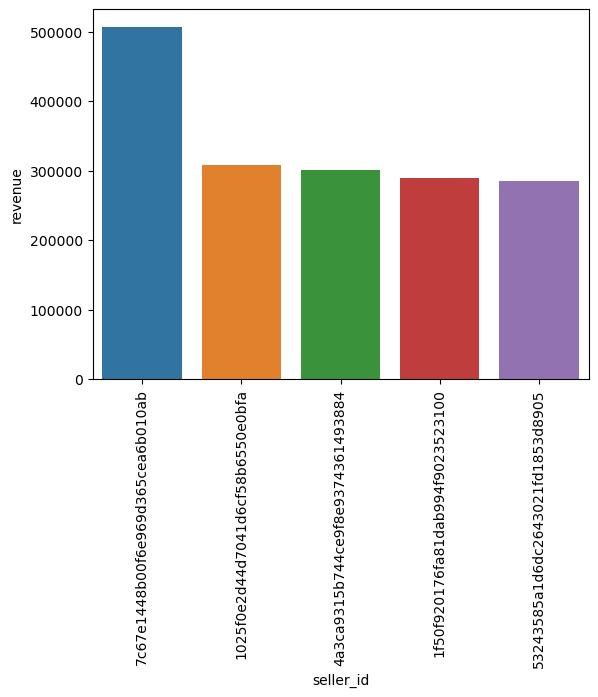

In [32]:
query = """ select *, dense_rank() over(order by revenue desc) as rn from
(select order_items.seller_id, sum(payments.payment_value)
revenue from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["seller_id", "revenue", "rank"])
df = df.head()
sns.barplot(x = "seller_id", y = "revenue", data = df)
plt.xticks(rotation = 90)
plt.show()

## Calculate the moving average of order values for each customer over their order history

In [16]:
query = """ select customer_id, order_purchase_timestamp,
ROUND(avg(payment) over(partition by customer_id order by order_purchase_timestamp rows between 2 preceding and current row),2) as mov_avg
from
(select orders.customer_id, orders.order_purchase_timestamp,
payments.payment_value as payment
from payments join orders
on payments.order_id = orders.order_id) as a"""

cur.execute(query)
data = cur.fetchall()
dF=pd.DataFrame(data,columns=["Customer_id","OPT","Mov_avg"])
dF.head()

,Customer_id,OPT,Mov_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01


## Calculate the cumulative sales per month for each year

In [17]:
query = """ select years, months, payment, sum(payment) 
over(order by years, months) cumulative_sales from 
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value), 2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years, months order by years, months) as a"""

cur.execute(query)
data = cur.fetchall()
dF=pd.DataFrame(data,columns=["Year","Months","Payment","Cummulative_sales"])
dF.head()

,Year,Months,Payment,Cummulative_sales
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39


## Calculate the year-over-year growth rate of total sales

In [24]:
query = """ WITH a AS (select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value), 2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years order by years)

SELECT years,((payment-LAG(payment,1) OVER(ORDER BY years))/LAG(payment,1) OVER(ORDER BY years))*100 FROM a

"""
cur.execute(query)
data = cur.fetchall()
dF=pd.DataFrame(data,columns=["Year","yoy % growth"])
dF.head()

,Year,yoy % growth
0,2016,NaN
1,2017,12112.703761
2,2018,20.000924


## Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase

In [25]:
query = """ with a as (select customers.customer_id,
min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id),

b as(select a.customer_id, count(distinct orders.order_purchase_timestamp)
from a join orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp <
date_add(first_order, interval 6 month)
GROUP BY a.customer_id)

select 100 * (count(distinct a.customer_id) / count(distinct b.customer_id))
from a left join b
on a.customer_id = b.customer_id;
"""
cur.execute(query)
data = cur.fetchall()
dF=pd.DataFrame(data)
dF.head()

,0
0,None


There is no such data in our db.

## Identify the top 3 customers who spent the most money in each year


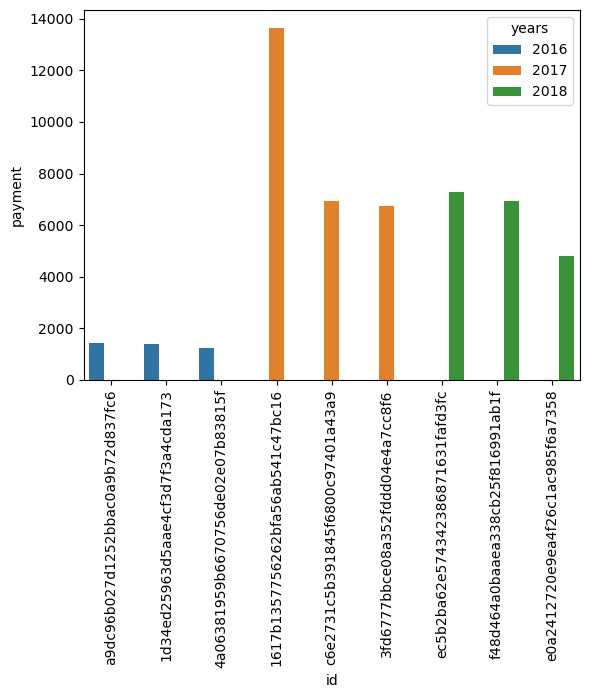

In [27]:
query = """select years, customer_id, payment, d_rank
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments 
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <= 3 ;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years","id","payment","rank"])
sns.barplot(x = "id", y = "payment", data = df, hue = "years")
plt.xticks(rotation = 90)
plt.show()